In [1]:
import pandas as pd 
import numpy as np  
import matplotlib.pyplot as plt
import math
import datetime
from datetime import timedelta,date
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from keras.models import Model, Sequential, load_model
from keras.callbacks import EarlyStopping
from keras.losses import MeanSquaredError, Huber,MeanAbsoluteError
from keras.layers import Dense, LSTM, Reshape,Dropout,Bidirectional
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from vmdpy import VMD

In [85]:
list_years = [2021,2022]
aux_list = []
for year in list_years:
    df_read = pd.read_csv("CURVA_CARGA_"+str(year)+".csv", sep = ";")
    aux_list.append(df_read)
    
df_load = pd.concat(aux_list)

In [86]:
df_load.columns

Index(['id_subsistema', 'nom_subsistema', 'din_instante',
       'val_cargaenergiahomwmed'],
      dtype='object')

In [87]:
df_load = df_load.rename(columns = {'din_instante': 'datetime',
                          'nom_subsistema':'sub',
                          'val_cargaenergiahomwmed':'carga_sub',
                          'id_subsistema':'id_sub'} )

In [88]:
df_load = df_load.pivot_table(index = ["datetime"], columns=["id_sub"], values = "carga_sub")
df_load.reset_index(inplace = True)
df_load.head()

id_sub,datetime,N,NE,S,SE
0,2021-01-01 00:00:00,5511.801,10343.540,9060.566986,33498.352
1,2021-01-01 01:00:00,5470.133,10428.167,9020.190988,33183.006
2,2021-01-01 02:00:00,5497.591,10428.881,8696.537996,32630.701
3,2021-01-01 03:00:00,5508.803,10380.594,8338.067001,31738.470
4,2021-01-01 04:00:00,5408.828,10244.215,8081.066000,31233.243


In [89]:
#df_load.drop("id_sub", axis =1, inplace = True)

df_load['datetime'] = pd.to_datetime(df_load['datetime'])

#Summing all coluns to reach total load
sub_markets =  df_load.select_dtypes(include=['float64', 'int64']).columns.to_list()
df_load['total_load'] = df_load[sub_markets].sum(axis = 1)
df_load.head()

id_sub,datetime,N,NE,S,SE,total_load
0,2021-01-01 00:00:00,5511.801,10343.540,9060.566986,33498.352,58414.259986
1,2021-01-01 01:00:00,5470.133,10428.167,9020.190988,33183.006,58101.496988
2,2021-01-01 02:00:00,5497.591,10428.881,8696.537996,32630.701,57253.710996
3,2021-01-01 03:00:00,5508.803,10380.594,8338.067001,31738.470,55965.934001
4,2021-01-01 04:00:00,5408.828,10244.215,8081.066000,31233.243,54967.352000


In [91]:
df_load.drop(columns = sub_markets, axis = 1, inplace = True)

In [92]:
df_load.head()

id_sub,datetime,total_load
0,2021-01-01 00:00:00,58414.259986
1,2021-01-01 01:00:00,58101.496988
2,2021-01-01 02:00:00,57253.710996
3,2021-01-01 03:00:00,55965.934001
4,2021-01-01 04:00:00,54967.352000


In [93]:
#Ciclical encoding datetime object:
day = 1
year = day*365

#hourly data, each day has 24 timesteps 
steps_per_day = 24

#Convert into an number
timestamp_s = df_load['datetime'].map(datetime.datetime.timestamp)

In [94]:
#Ciclical enconding for sin and cos
df_load = df_load.assign(year_sin = (np.sin(timestamp_s * (2*np.pi/year))).values)
df_load = df_load.assign(year_cos = (np.cos(timestamp_s * (2*np.pi/year))).values)
df_load = df_load.assign(day_sin = (np.sin(timestamp_s * (2*np.pi/day))).values)
df_load = df_load.assign(day_cos = (np.cos(timestamp_s * (2*np.pi/day))).values)

#Save the dates into another variable and remove it from the original dataframe
saved_dates = df_load['datetime']
saved_dates = saved_dates.reset_index(drop=True)

df_load.drop('datetime', axis = 1, inplace = True)

In [95]:
df_load.head()

id_sub,total_load,year_sin,year_cos,day_sin,day_cos
0,58414.259986,-0.811539,0.584298,-3.116654e-07,1.0
1,58101.496988,-0.972118,-0.234491,-2.926982e-07,1.0
2,57253.710996,-0.455907,-0.890028,-2.737310e-07,1.0
3,55965.934001,0.377708,-0.925925,-2.547638e-07,1.0
4,54967.352000,0.948362,-0.317191,-2.357966e-07,1.0


In [96]:
def vmd(windspeed):
    
    alpha = 2000     # moderate bandwidth constraint  
    tau = 0           # noise-tolerance (no strict fidelity enforcement)  
    k_nmodes = 40             # n modes  
    DC = 0             # no DC part imposed  
    init = 0           # initialize omegas uniformly  
    tol = 1e-6
    u, u_hat, omega = VMD(windspeed,alpha,tau,k_nmodes,DC,init,tol)

    return(u)

In [97]:
#Applying Variational Mode Decomposition into the wind speed values:
#The objective is to decompose de original wind speed into K series
#In which the sum of those K series are equal to the original wind speed value for each time step

total_load = df_load['total_load'].values
u = vmd(total_load)

In [100]:
print(len(u[0]))
print(len(df_load))

17520
17520


In [101]:
#Iterate trought the decomposed wind speed array (u) and append its values to a column in the df_wind dataframe
label_columns = []

for i in range(len(u)):
    col_name = 'load_dec_' + str(i+1)
    df_load[col_name] = u[i]  
    label_columns.append('load_dec_'+str(i+1))

#real_windspeed = df_wind['wind'].values

df_load = df_load.drop(['total_load'],axis = 1)

In [102]:
n = len(df_load)

# Split 70:20:10 (train:validation:test)
train_df = df_load[0:int(n*0.7)]
val_df = df_load[int(n*0.7):int(n*0.9)]
test_df = df_load[int(n*0.9):]

#define batch training size
batch_size = 32

#retrieve the max and min values of each feature. This will be used to bring those values back to the original
#dimesion after scalling it to train the model
min_values = train_df.min()
max_values = train_df.max()

In [104]:
#Scaling the dataframes to train
scaler = MinMaxScaler()
scaler.fit(train_df)

scal_df = df_load.copy()
scal_df[scal_df.columns] = scaler.transform(df_load[df_load.columns])

scal_train_df = train_df.copy()
scal_train_df[scal_train_df.columns] = scaler.transform(train_df[train_df.columns])

scal_val_df = val_df.copy()
scal_val_df[scal_val_df.columns] = scaler.transform(val_df[val_df.columns])

scal_test_df = test_df.copy()
scal_test_df[scal_test_df.columns] = scaler.transform(test_df[test_df.columns])

In [113]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=scal_train_df, val_df=scal_val_df, test_df=scal_test_df, 
                 label_columns=None, min_values=min_values,max_values=max_values,batch_size=batch_size,plot_col=label_columns,
                 steps_per_day=steps_per_day):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.train_min = train_df.min()
        self.train_max = train_df.max()

        self.steps_per_day = steps_per_day

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col=label_columns, max_subplots=3):
        inputs, labels = self.sample_batch

        fig = plt.figure(figsize=(18, 8))
        plot_col_index = [self.column_indices[col] for col in plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel('Windspeed (m/s)')
            #plt.ylim(0,20)
            
            sliced_inputs = inputs[:,:,-len(plot_col):]
            original_scale_inputs = scale_back(sliced_inputs,min_values,max_values,plot_col)
            summed_inputs = tf.math.reduce_sum(original_scale_inputs,axis=2,keepdims=False,name=None)
            
            plt.plot(self.input_indices, 
                     summed_inputs[n],
                     
                     label='Inputs', 
                     marker='.',
                     c='#2E294E',
                     zorder=-10)

            if self.label_columns:
                label_col_index = [self.label_columns_indices.get(col, None) for col in plot_col]
            else:
                label_col_index = plot_col_index

            if None in label_col_index:
                continue
            
            original_scale_labels = scale_back(labels,min_values,max_values,plot_col)
            summed_label = tf.math.reduce_sum(original_scale_labels,axis=2,keepdims=False,name=None)
            #label_avg = calc_ws_avg(summed_label[n],steps_per_day)
            
            forecasting_period = int((len(summed_label[n]))/steps_per_day)

            plt.plot(self.label_indices, 
                        summed_label[n],
                        label='Labels',
                        marker='.',
                        c='#541388'
                        )
           
            if model is not None:

                predictions = model(inputs)
                original_scale_predictions = scale_back(predictions,min_values,max_values,plot_col)
                summed_predictions = tf.math.reduce_sum(original_scale_predictions,axis=2,keepdims=False,name=None)
                #predictions_avg = calc_ws_avg(summed_predictions[n],steps_per_day)

                plt.plot(self.label_indices, 
                            summed_predictions[n], 
                            label='Predictions',
                            marker='.',
                            c='#D90368'
                            )
                
                plt.text(x=5,y=17,s='avg_ws')

                x_0 = int(len(summed_inputs[n]))
                text_position = x_0 

                plt.rcParams.update({'font.size': 7})

                # for day in range(forecasting_period):
                    
                #     text_string = 'day_' + str(day+1) + ': r = ' + str(label_avg[day]) + '| p = '+ str(predictions_avg[day])
                    
                #     plt.text(x=text_position + 3, y=17, s=text_string)
                #     plt.axvline(x=text_position, color='black',ymin = 0, ymax = (18/20),ls=':')
                #     text_position = text_position + steps_per_day

                    
            if n == 0:
                fig.legend()

        plt.xlabel('Time [daily]')
        return(fig)
    
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=batch_size
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.test))
            self._sample_batch = result
        return result

In [106]:
def compile_and_fit(model, window, patience=3, max_epochs=30):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='auto')
    
    model.compile(loss=MeanAbsoluteError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [114]:
input_days = 3
forecast_days = 7
features = len(df_load.columns)

label_columns = label_columns
input_width = steps_per_day*input_days
label_width = steps_per_day*forecast_days
shift = steps_per_day*forecast_days

mo_val_performance = {}
mo_performance = {}

multi_step_window = DataWindow(input_width = input_width, 
                            label_width=label_width, 
                            shift=shift, 
                            label_columns=label_columns,
                            batch_size=batch_size,
                            steps_per_day=steps_per_day)

In [108]:
def scale_back(scaled_values,val_min,val_max,label_columns,variable = 'windspeed'):

        if variable == 'windspeed':       
                min_values = val_min.tail(len(label_columns)).values
                max_values = val_max.tail(len(label_columns)).values
                
        elif variable == 'val_loss':
                min_values = val_min.head(1).values
                max_values = val_max.head(1).values

        scaled_back = scaled_values * (max_values - min_values) + min_values

        return scaled_back

In [109]:
def plot_loss(history):

    fig,ax= plt.subplots()

    ax.plot(range(len(hist.history['loss'])),hist.history['loss'],label='loss',color='#D90368')
    ax.plot(range(len(hist.history['val_loss'])),hist.history['val_loss'],label='val_loss',color='#2E294E')

    ax.set_xlabel('epochs')
    ax.set_ylabel('loss')
    ax.set_title('training loss')
    leg = ax.legend()

    return(fig)

In [110]:
val_performance = {}
test_performance = {}

#Layers Units (LU)
first_lu = 16
seccond_lu = 32
third_lu = 64
forth_lu = 0

#Dropouts (DO)
first_do = 0.0
seccond_do = 0.0

teorical_lstm = Sequential([
    Bidirectional(LSTM(units = first_lu,input_shape=(input_width,features),return_sequences=True)),
    Dropout(first_do),
    Bidirectional(LSTM(units = seccond_lu,return_sequences=True)),
    Dropout(seccond_do),
    Bidirectional(LSTM(units = third_lu)),
    Dense(units=shift*len(label_columns)),
    Reshape((shift,len(label_columns)))
])

hist = compile_and_fit(teorical_lstm,multi_step_window)

val_performance['LSTM'] = teorical_lstm.evaluate(multi_step_window.val)
test_performance['LSTM'] = teorical_lstm.evaluate(multi_step_window.test,verbose = 0)

Epoch 1/30
376/376 [==============================] - 72s 144ms/step - loss: 0.1925 - mean_absolute_error: 0.1925 - val_loss: 0.1699 - val_mean_absolute_error: 0.1699
Epoch 2/30
376/376 [==============================] - 50s 133ms/step - loss: 0.1472 - mean_absolute_error: 0.1472 - val_loss: 0.1257 - val_mean_absolute_error: 0.1257
Epoch 3/30
376/376 [==============================] - 46s 122ms/step - loss: 0.1128 - mean_absolute_error: 0.1128 - val_loss: 0.0989 - val_mean_absolute_error: 0.0989
Epoch 4/30
376/376 [==============================] - 47s 124ms/step - loss: 0.0875 - mean_absolute_error: 0.0875 - val_loss: 0.0813 - val_mean_absolute_error: 0.0813
Epoch 5/30
376/376 [==============================] - 45s 120ms/step - loss: 0.0732 - mean_absolute_error: 0.0732 - val_loss: 0.0730 - val_mean_absolute_error: 0.0731
Epoch 6/30
376/376 [==============================] - 45s 120ms/step - loss: 0.0645 - mean_absolute_error: 0.0645 - val_loss: 0.0660 - val_mean_absolute_error: 0.066

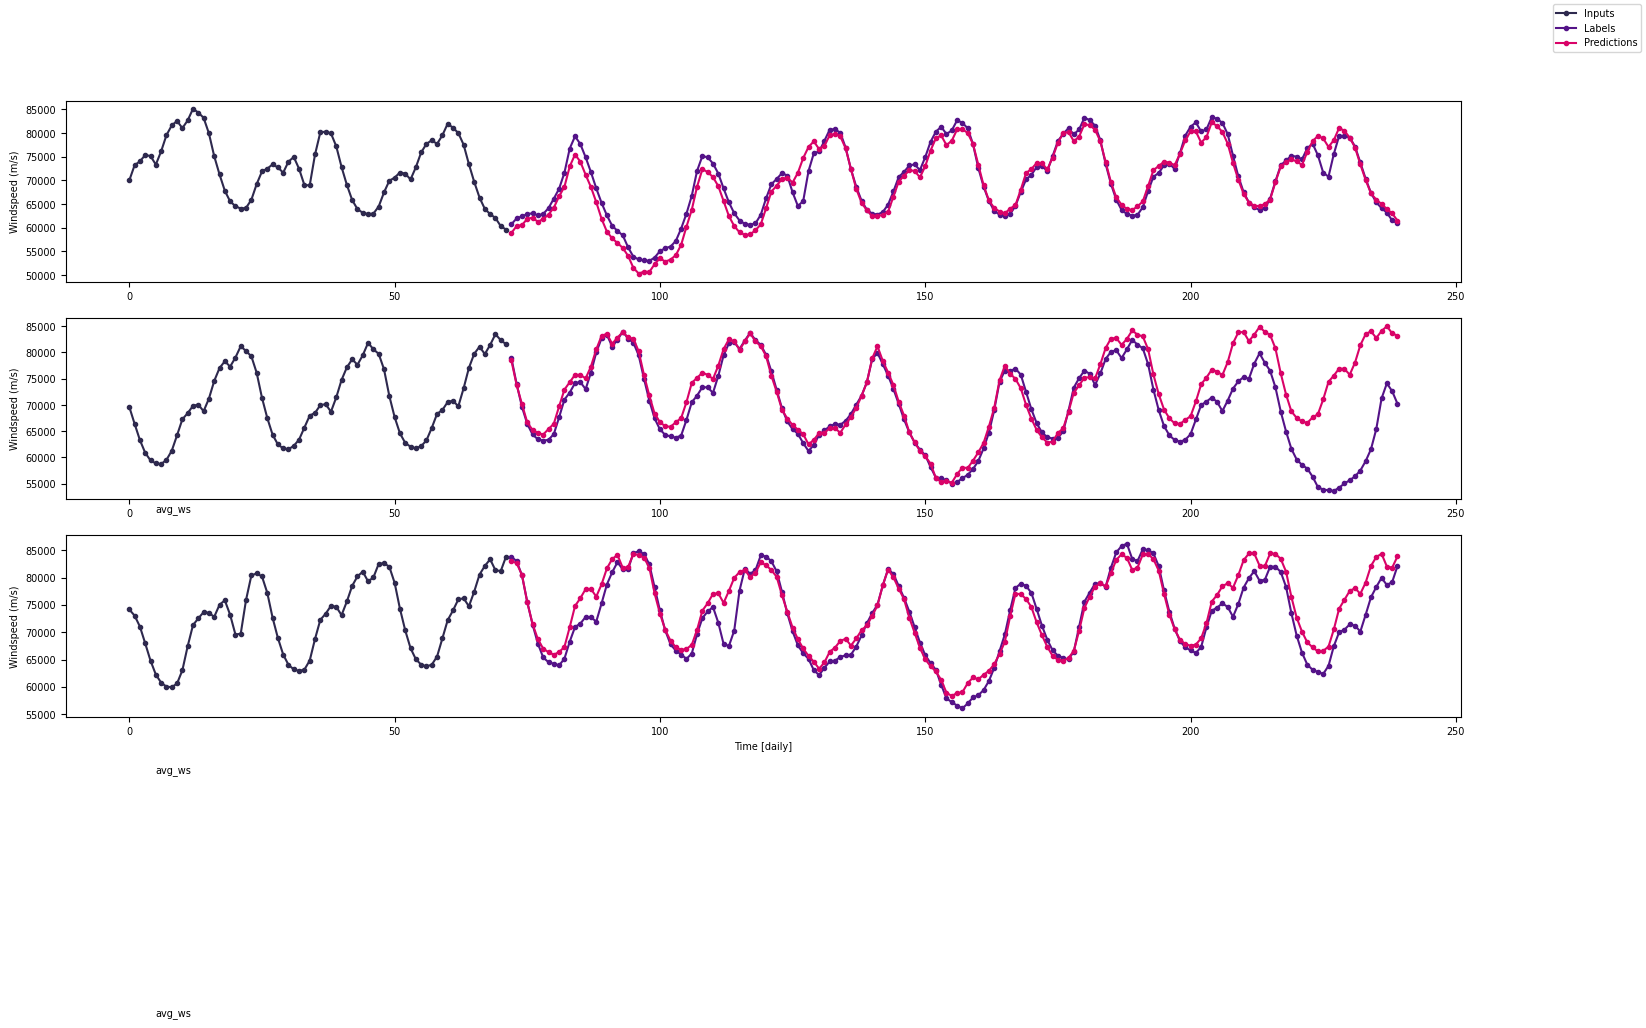

In [115]:
forecast = multi_step_window.plot(model = teorical_lstm)

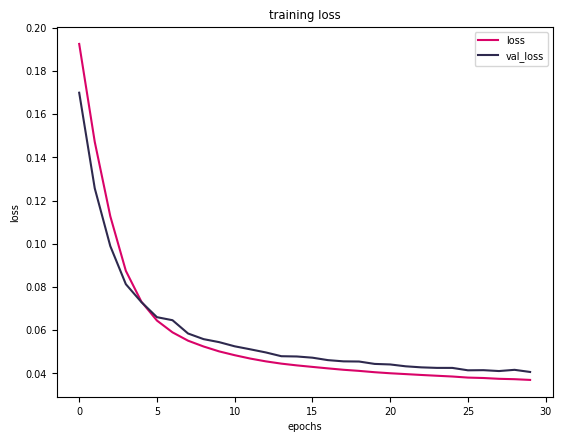

In [112]:
loss_fig = plot_loss(hist)

In [116]:
teorical_lstm.save('load_forecast.h5')

c:\Users\victo\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
teorical_lstm.save('load_forecast.keras')